Adaptacion de [Basic NLP, EDA & TensorFlow - Real or Fake tweets](https://www.kaggle.com/galvaowesley/basic-nlp-eda-tensorflow-real-or-fake-tweets) de Wesley Galvão

Basic NLP with TensorFlow - Prediction of real or fake disaster tweets
===
​
Wesley Galvão 
​
Aug, 2020
​

# Introduction
​
This notebook contains an introductory approach to Natural Language Processing techniques in order to model and build a machine model that predicts which Tweets are about real disasters and which one's aren't. 
​
For this purpose, techniques of exploratory data analysis, cleaning and tensorflow library were used.
​
This work was based on others and was properly referenced in the references section.
​
I hope you enjoy reading.  

# About the Dataset

According the [competition description](https://www.kaggle.com/c/nlp-getting-started/data), the data characteristics are:

Each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* he location the tweet was sent from (may also be blank)

Columns

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


## Importing required libraries

In [43]:
import pandas as pd # data processing
import numpy as np  # linear algebra

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# TensorFlow and libraries for preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Preprocessing libraries
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import gensim
import string
# Counter function
from collections import Counter

#WordCloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
# create text with Markdown from within code cells¶
from IPython.display import Markdown as md 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading dataset

In [44]:
# Load the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

## Dataset shape

In [45]:
# Head
train_df.head(4)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1


In [46]:
# Datasets shape
print('Train dataset:\n{} rows\n{} columns'.format(train_df.shape[0], train_df.shape[1]))
print('\nTest dataset:\n{} rows\n{} columns'.format(test_df.shape[0], test_df.shape[1]))

Train dataset:
7613 rows
5 columns

Test dataset:
3263 rows
4 columns


# Exploratory Data Analysis

In this section we'll perform some EDA techiniques, like chart plotting and features summarising. 

## Target variable characteristics

Analyses of `target` column.

### Amount

We can get the amount of real disaster and not real disaster tweets. 

In [47]:
# Count target values by its factor
x = train_df.target.value_counts()
md("The amount disaster tweets is {}. And the amount for not disaster is {}.".
     format(x[1], x[0]))
md

IPython.core.display.Markdown

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Target')

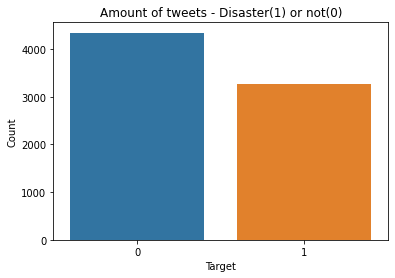

In [48]:
# Add title
plt.title("Amount of tweets - Disaster(1) or not(0)")
# Bar chart showing amount of both target values
sns.barplot(x.index, x)
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Target")

### Proportion

We can also calculate target values proportion and visualize them. 

In [49]:
proportion = x/train_df.shape[0] # Compute the tweets proportion by target
md("The percentual of disaster tweets is {}%, and {}% for not disaster.".
     format(round(proportion[1]*100,0),round(proportion[0]*100, 0)))

The percentual of disaster tweets is 43.0%, and 57.0% for not disaster.

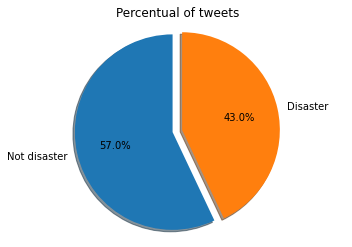

In [50]:
# Reference: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
# Pie chart

fig1, ax1 = plt.subplots()
ax1.pie(proportion, 
        explode = (0, 0.1), # only "explode" the 2nd slice
        labels  = ['Not disaster', 'Disaster'], 
        autopct = '%1.1f%%',
        shadow = True, 
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentual of tweets")
plt.show()

## Text variable characteristics

To understand the distribution of tweets, it's necessary explore the `text` column. First, we create two new features to get some statistics.

### New features

The new features are number of characters (or text lenght) and number of words for each tweet.

In [51]:
# Create a new feature with text lenght, or number of characters
train_df['length'] = train_df['text'].str.len()
# Create a new feature with number of words
train_df['num_words'] = train_df['text'].str.split().map(lambda x: len(x))
train_df.head(3)

,id,keyword,location,text,target,length,num_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22


### Text lenght

Main statistics

In [52]:
# Text length summary by target
train_df.groupby(['target']).length.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,95.706817,35.885924,7.0,68.0,101.0,130.0,157.0
1,3271.0,108.113421,29.309854,14.0,88.0,115.0,136.0,151.0


Now, we plot the histogram to visualize the distribution. 

Text(0.5, 1.0, 'Disaster')

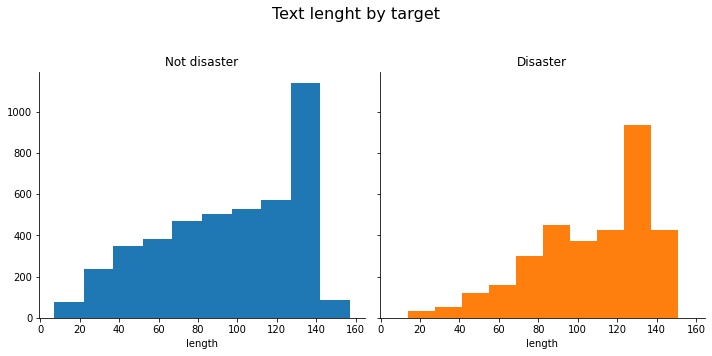

In [53]:
# Facet a plot by target column
g = sns.FacetGrid(train_df, col = 'target', height = 5, hue = 'target')
# Plot a histogram chart
g.map(plt.hist, "length")
# Adjust title position
g.fig.subplots_adjust(top=0.8)
# Add general title
g.fig.suptitle('Text lenght by target', fontsize=16)
# Set title to each chart
axes = g.axes.flatten()
axes[0].set_title("Not disaster")
axes[1].set_title("Disaster")

### Number of words

Similarly, here are some statistics and graphs that show the distribution of number of words.

In [54]:
# number of words summary by target
train_df.groupby(['target']).num_words.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,14.704744,6.161564,1.0,10.0,15.0,19.0,31.0
1,3271.0,15.167533,5.096806,2.0,11.0,15.0,19.0,30.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Disaster')

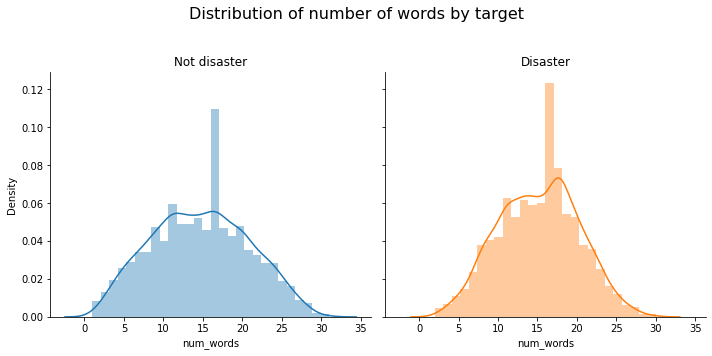

In [55]:
# Facet a plot by target column
g = sns.FacetGrid(train_df, col = 'target', height = 5, hue = 'target')
# Plot a histogram chart
g.map(sns.distplot, "num_words")
# Adjust title position
g.fig.subplots_adjust(top=0.8)
# Add general title
g.fig.suptitle('Distribution of number of words by target', fontsize=16)
# Set title to each chart
axes = g.axes.flatten()
axes[0].set_title("Not disaster")
axes[1].set_title("Disaster")

Text(0.5, 0, 'Target')

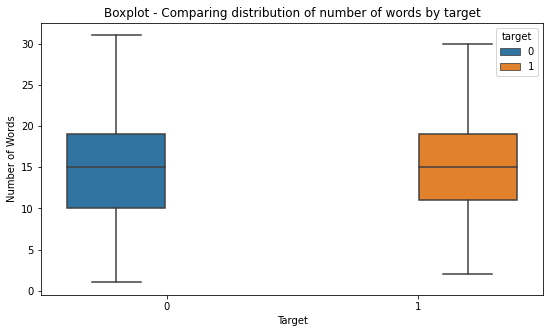

In [56]:
plt.figure(figsize=(9,5))
# Add title
plt.title("Boxplot - Comparing distribution of number of words by target")
# Boxplot
sns.boxplot(x = "target", y = "num_words", hue="target", data = train_df)
# Add label for vertical axis
plt.ylabel("Number of Words")
# Add label for hotizontal axis
plt.xlabel("Target")

#### Unique words

In [57]:
# Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#kln-160
# Function to compute many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [58]:
# Unique words
text_values = train_df["text"]

counter = counter_word(text_values)
md("The training dataset has {} unique words".format(len(counter)))

The training dataset has 31924 unique words

## Keyword variable characteristics

What are the top 20 keywords? 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

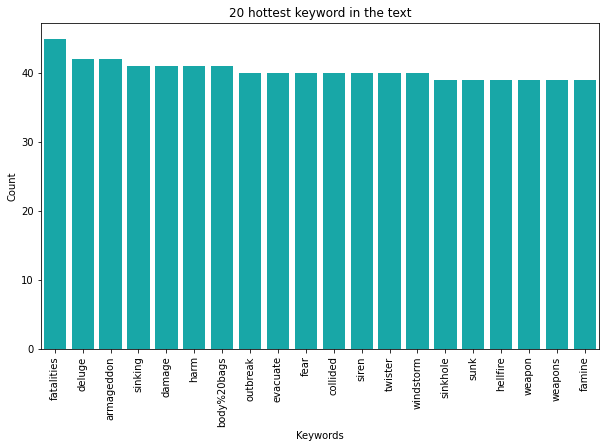

In [59]:
# Groups the top 20 keywords
x = train_df.keyword.value_counts()[:20]
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("20 hottest keyword in the text")
# Bar chart showing amount of both target values
sns.barplot(x.index, x, color="c")
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Keywords")
# Rotate the label text for hotizontal axis
plt.xticks(rotation=90)

### Word Cloud

We can explore the most used keywords through the word cloud graphic.

#### Function to create a Word Cloud

In [60]:
# Reference: https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#6.-Train-Test-Split
# Download a image to mask the wordcloud
!wget --no-check-certificate \
  https://i.imgur.com/tyCaXHH.jpg \
    -O /tmp/Twitter_Logo.jpg

STOPWORDS.add('NaN')  # remove NaN to the world Cloud
STOPWORDS.add('https') # remove https to the world Cloud

def create_word_cloud(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # convert each val to string type 
        val = str(val)
        # split the value 
        tokens = val.split() 
        # Converts each token to lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '
            
    maskArray = np.array(Image.open("/tmp/Twitter_Logo.jpg"))
    wordcloud = WordCloud(width = 5000, height = 4000,
                    background_color ='white',
                    mask = maskArray,      
                    stopwords = stopwords,
                    min_font_size = 10)
    wordcloud.generate(comment_words)   
    
    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12)) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

--2022-12-01 02:41:40--  https://i.imgur.com/tyCaXHH.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.20.193
Connecting to i.imgur.com (i.imgur.com)|151.101.20.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103166 (101K) [image/jpeg]
Saving to: ‘/tmp/Twitter_Logo.jpg’

/tmp/Twitter_Logo.j 100%[===================>] 100.75K  --.-KB/s    in 0.01s   

2022-12-01 02:41:40 (9.06 MB/s) - ‘/tmp/Twitter_Logo.jpg’ saved [103166/103166]



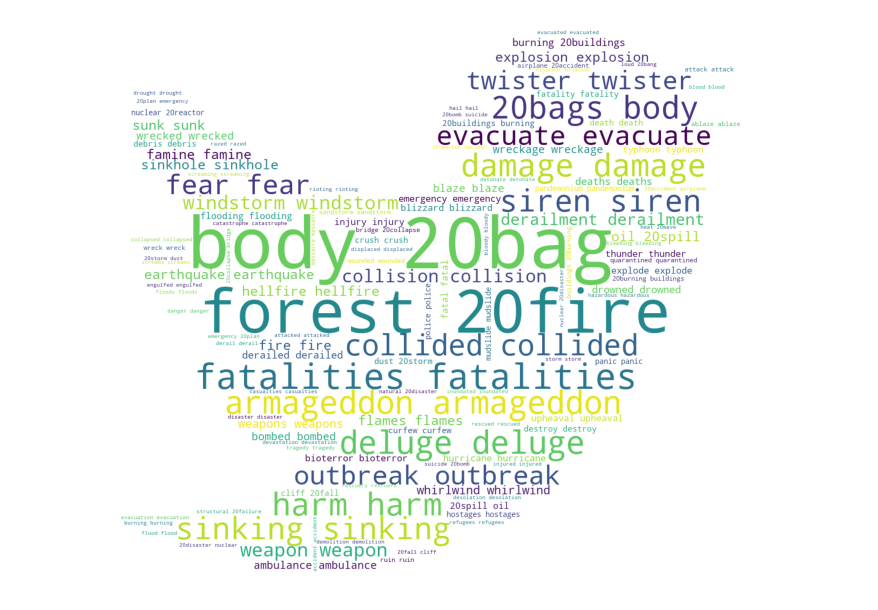

In [61]:
# Create a WordCloud from keyword values
text = train_df.keyword.values
create_word_cloud(text)

## Location variable characteristics

What are the top 20 location? 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

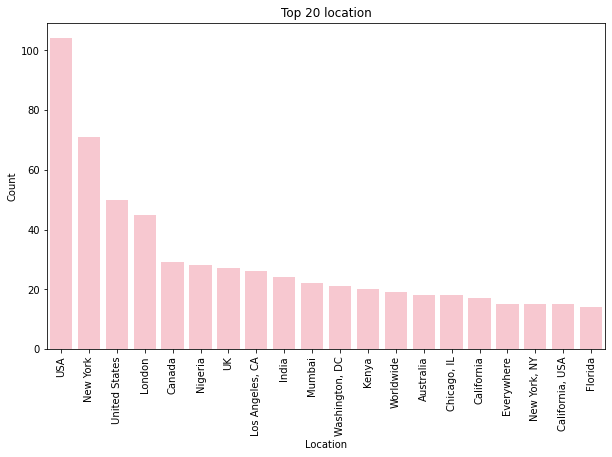

In [62]:
# Groups the top 20 location
x = train_df.location.value_counts()[:20]
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("Top 20 location")
# Bar chart showing amount of both target values
sns.barplot(x.index, x, color = "pink")
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Location")
# Rotate the label text for hotizontal axis
plt.xticks(rotation=90)

# Challenge

In [93]:
######Preprocessing
####Data Cleaning
#removing emoji                   # Reference https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
import re
import sys
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

print(remove_emoji("Oh no, a hurricane is happening here 🌪️🚫😫"))
# Apply removing emoji function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_emoji(x))

Oh no, a hurricane is happening here 


In [64]:
#removing URLS                    # Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#5.-Cleaning-the-text


# Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#5.-Cleaning-the-text
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
def remove_url(text):
    no_url = pattern.sub(r'',text)
    return no_url

# Removing URL example
example = "Hey, look at this Data Science platform: https://www.kaggle.com"
remove_url(example)

# Apply removing URL function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_url(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_url(x))


In [97]:
#removing HTML Tags               # Reference https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning

example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))




Real or Fake
Kaggle 
getting started



In [98]:
train_df['text'] = train_df['text'].apply(lambda x: remove_html(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_html(x))

In [94]:
#Convert abbrevation to text            # reference: https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word



In [96]:
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text
train_df["text"] = train_df["text"].apply(lambda x: convert_abbrev_in_text(x))
test_df["text"] = test_df["text"].apply(lambda x: convert_abbrev_in_text(x))

In [67]:
#removing stop words                    # Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#kln-160

def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  
    text = text.lower()  
    # split to array(default delimiter is " ") 
    text = text.split()      
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)    
            
    return text
# Apply clean text
train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))


In [68]:
#####Splitin trining dataset and testing dataset

In [69]:
# Create training subsets




In [70]:
# Create testing subsets



In [71]:
#####Tokenization

In [72]:
# Initialize tokenizer


# Fitting the training dataset


# Create a words dictionary



In [73]:
#####Sequencing
# Create sequences of tokens that represent each sentence 





In [74]:
####Padding
# Create padding sequences for training sentences 





In [75]:
# Create padding sequences for testing sentences 






In [76]:
#####Modeling and Training
# Convert the sets to array to get it to work with TensorFlow





In [77]:
####Modeling    # Reference https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences
# Create a model





In [78]:
# Modelo compile for binary classification



In [79]:
# Model summary




In [80]:
# Train the model




In [81]:
#### Evaluation
#plot loss and accuracy





In [82]:
###Confusion matrix
# predict clases because is classification problem with the split test




In [83]:
# Showing Confusion Matrix





In [84]:
####Predicting
# Sequencing



In [85]:
# Padding



In [86]:
# Apply model prediction on submission sequences


### Removing HTML tags

In [87]:
# Reference https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning
pattern = re.compile('<.*?>')
def remove_html(text):
    no_html = pattern.sub(r'',text)
    return no_html

In [88]:
# Removing HTML tags example
example = """<div>
<h1>NLP TensorFlow</h1>
<p>Predicting sarcastic sentences by Wesley Galvão </p>
<a href="https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences">Check it out</a>
</div>"""
remove_html(example)

'\nNLP TensorFlow\nPredicting sarcastic sentences by Wesley Galvão \nCheck it out\n'

In [89]:
# Apply removing HTML tags function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_html(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_html(x))

### Convert abbreviation to text

In [90]:
# Dictionary of abbreviations
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [91]:
# reference: https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [92]:
# Appy abbreviation to text
train_df['text'] = train_df['text'].apply(lambda x: convert_abbrev_in_text(x))
test_df['text'] = test_df['text'].apply(lambda x: convert_abbrev_in_text(x))